In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - SB02_parameters.ipynb
# AUTHOR - James Lane
# PROJECT - OHStars
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Generate orbital parameters for the SB02 stellar sample. Sample 5D gaia kinematics with covariances and
determine orbital parameters and uncertainties using a MC approach.
'''

__author__ = "James Lane"

In [65]:
### Imports

## Basic
import numpy as np
import sys, os, pdb, warnings
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib import patches

## Astropy
from astropy import table
from astropy import units as apu
from astropy.utils.exceptions import AstropyWarning

## galpy
from galpy import orbit
from galpy import potential
from galpy import actionAngle
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv
from galpy.util import bovy_plot as gpplot

# Project-specific
sys.path.append('../../src')
import ohstars.analysis
import ohstars.potential

In [3]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['text.usetex'] = True

# Meta
## Future Work
- Add in extra systematic error, 0.035 mas? Following Gaia, Helmi + 2018

## Information
- Gaia co-variance information: https://www.aanda.org/articles/aa/pdf/2012/07/aa18807-12.pdf
- Myeong 2019 on GE & Sequoia https://ui.adsabs.harvard.edu/abs/2019arXiv190403185M/abstract
- Myeong 2018 on Sausage GCs https://ui.adsabs.harvard.edu/abs/2018ApJ...863L..28M/abstract
- Vasiliev 2019 on GC kinematics https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.2832V/abstract

# Preparation
## Keywords

In [4]:
# Number of samples
n_samples = 100

# Integration keywords
# t_orbit = [2,10,1,40,3,2] # Gyr

## Read Gaia Data

In [5]:
# Filename
gaia_filename = '../../data/gaia/SB02_results.vot'
# gaia_filename = '../../data/gaia/Gaia_DR2_SB02_Matched_Results.csv'

In [6]:
# gaia_dtypes = ['U20','int','float','float','float','float','float','float','float','float','float','float']
# gaia_data = np.genfromtxt(gaia_filename, comments='#', dtype=gaia_dtypes)

# Read the file
with warnings.catch_warnings():
    warnings.simplefilter('ignore', AstropyWarning)
    tab_gaia = table.Table.read(gaia_filename)
###w

n_stars = len(tab_gaia)

In [7]:
# tab_gaia

In [8]:
aAS = actionAngle.actionAngleStaeckel(pot=ohstars.potential.McMillan2017, delta=0.45, c=True)

## Read RV Data

In [9]:
sb02_filename = '../../data/gaia/SB02_RV.csv'

In [10]:
tab_vrad = table.Table.read(sb02_filename, format='csv')
vrad_name = tab_vrad['star_name'].data
vrad = tab_vrad['rv'].data
vrad_err = tab_vrad['rv_err'].data

In [11]:
# tab_vrad

## Function to evaluate orbit parameters

In [47]:
 def evaluate_orbit_parameters_numerical(pot, potname, tab, vrad, vrad_err, n_samples, star_names):
    '''evaluate_orbit_parameters_numerical:
    
    Args:
    
    Returns:
        
    '''
    n_stars = len(star_names)
    n_params = 10
    all_stats = np.zeros( ( n_stars, n_params, 3 ) )
    
    if potname == 'McMillan2017':
        m17_ro = 8.21
        m17_vo = 233.1
    ##fi
    
    # Make the actionAngle object
    aAS = actionAngle.actionAngleStaeckel(pot=pot,delta=0.4,c=False)
    
    # Loop over all stars
    for i in tqdm_nb( range(n_stars) ):
        
        # Make the figure
        # fig = plt.figure( figsize=(15,8) )
        # axs = fig.subplots( nrows=2, ncols=3 )

        # Sample the data
        samples, _ = ohstars.analysis.sample_kinematics( tab[i], n_samples=n_samples )
        rv_samples = np.random.normal( vrad[i], vrad_err[i], size=n_samples )

        # Arrays to hold output parameters
        peri = np.zeros(n_samples)
        apo = np.zeros(n_samples)
        Lz = np.zeros(n_samples)
        Tr = np.zeros(n_samples)
        ecc = np.zeros(n_samples)
        zmax = np.zeros(n_samples)
        energy = np.zeros(n_samples)
        Jr = np.zeros(n_samples)
        Jphi = np.zeros(n_samples)
        Jz = np.zeros(n_samples)

        # Loop over the trials
        for j in range(n_samples):

            # Unpack the sample:
            ra, dec, par, pmra, pmdec = samples[j]
            rv = rv_samples[j]
            dist = 1/par # In kpc

            # Now declare the orbit
            if potname == 'MWPotential2014':
                o = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True )
            if potname == 'McMillan2017':
                o = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True, 
                                 ro=m17_ro, vo=m17_vo)
            ##fi

            # Output            
            if potname == 'MWPotential2014':
                peri[j] = o.rperi(analytic=True, pot=pot, type='staeckel').value
                apo[j] = o.rap(analytic=True, pot=pot, type='staeckel').value
                Lz[j] = (o.vT(0)*o.R(0)).value
                Tr[j] = o.Tr(pot=pot, type='staeckel').value # Gyr
                ecc[j] = o.e(pot=pot, type='staeckel') # unitless
                zmax[j] = o.zmax(analytic=True, pot=pot, type='staeckel').value
                actions = aAS.actionFreqs(o(0))
            if potname == 'McMillan2017':
                peri[j] = o.rperi(pot=pot, type='staeckel', delta=0.45, analytic=True).value
                apo[j] = o.rap(pot=pot, type='staeckel', delta=0.45, analytic=True).value
                Lz[j] = (o.vT(0)*o.R(0)).value
                Tr[j] = o.Tr(pot=pot, type='staeckel', delta=0.45, analytic=True).value # Gyr
                ecc[j] = o.e(pot=pot, type='staeckel', delta=0.45, analytic=True) # unitless
                zmax[j] = o.zmax(pot=pot, type='staeckel', delta=0.45, analytic=True).value
                energy[j] = o.E(pot=pot).value # This potential is ~ 0 at infinity
                actions = aAS.actionsFreqs(o(0), c=True, delta=0.45)
                Jr[j] = actions[0][0] * m17_vo * m17_ro
                Jphi[j] = actions[1][0] * m17_vo * m17_ro
                Jz[j] = actions[2][0] * m17_vo * m17_ro
            ##fi
            
        # Arrays for statistics. Critical, order is: rperi, rapo, Lz, Tr, eccentricity, zmax
        params = np.array([peri,apo,Lz,Tr,ecc,zmax,energy,Jr,Jphi,Jz])
        
        # Loop over the parameters
        for k in range(n_params):
            
            # Get parameter and compute statistics
            this_param = params[k]
            param_median = np.median(this_param)
            param_c68p_l = np.sort(this_param)[int(0.16*n_samples)]
            param_c68p_u = np.sort(this_param)[int(0.84*n_samples)]
            
            all_stats[i,k,0] = param_median
            all_stats[i,k,1] = param_median-param_c68p_l
            all_stats[i,k,2] = param_c68p_u-param_median
        ###k
    
    # No output
    return all_stats

#def

# Determine Orbital Parameters
Use different potentials. Start with MWPotential2014 then use McMillan 2017

## McMillan2017

Loop over each star and determine orbital parameters

In [57]:
# Evaluate
pot = ohstars.potential.McMillan2017
potname = 'McMillan2017'
kinematics = evaluate_orbit_parameters_numerical(pot, potname, tab_gaia, 
                                                   vrad, vrad_err, 10, vrad_name)

A Jupyter Widget

# Plot interesting trends

In [58]:
# Prepare
n_params = 10
plot_names = [r'$r_{peri}$ [kpc]', r'$r_{apo}$ [kpc]', r'$L_{z}$ [kpc km s$^{-1}$]', r'$T_{r}$ [Gyr]', 
              r'eccentricity', r'$Z_{max}$ [kpc]',r'Energy [km$^{2}$ s$^{-2}$]',r'$J_{R}$ [kpc km s$^{-1}$]',
              r'$J_{\phi}$ [kpc km s$^{-1}$]',r'$J_{z}$ [kpc km s$^{-1}$]']

## Histograms

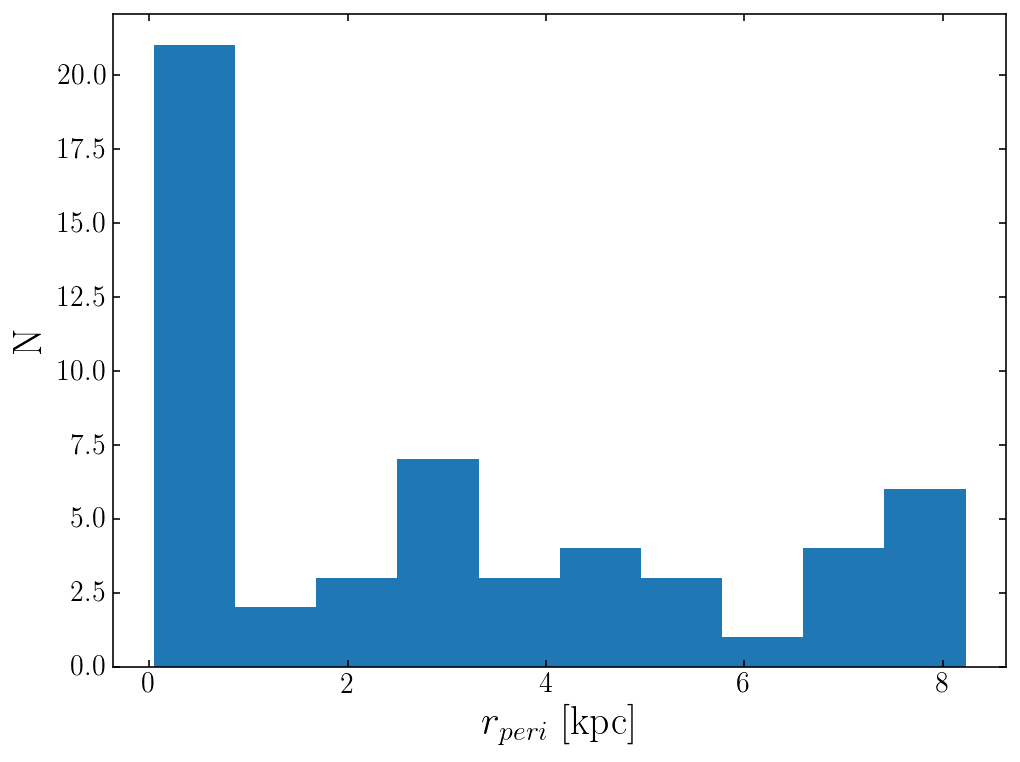

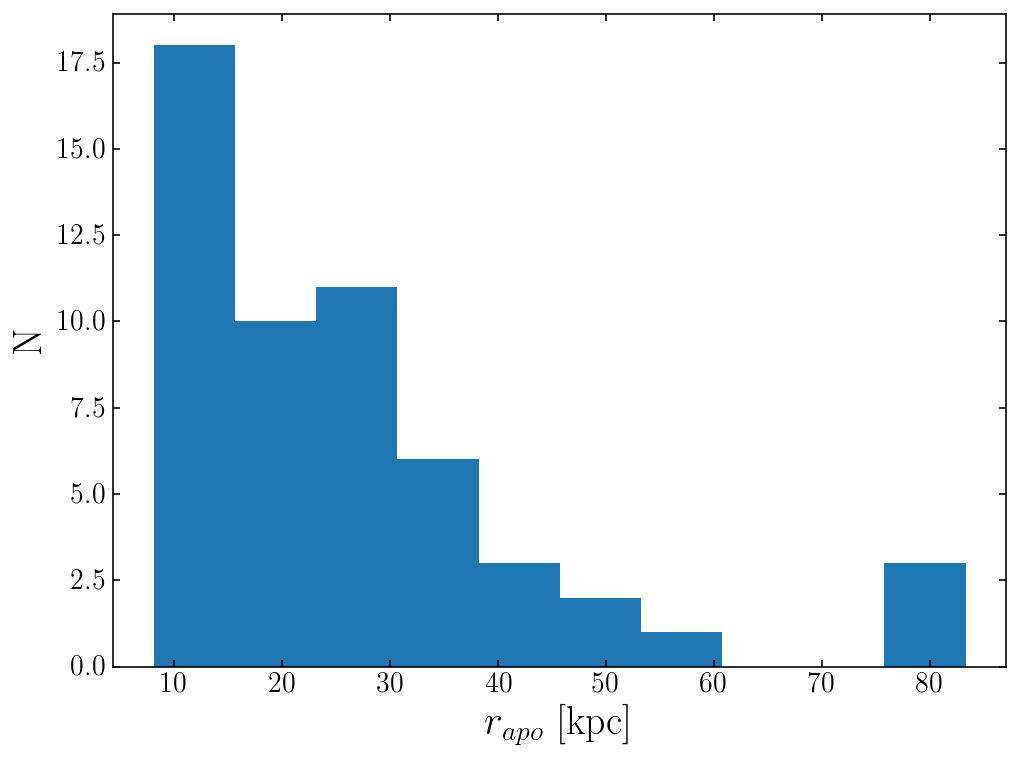

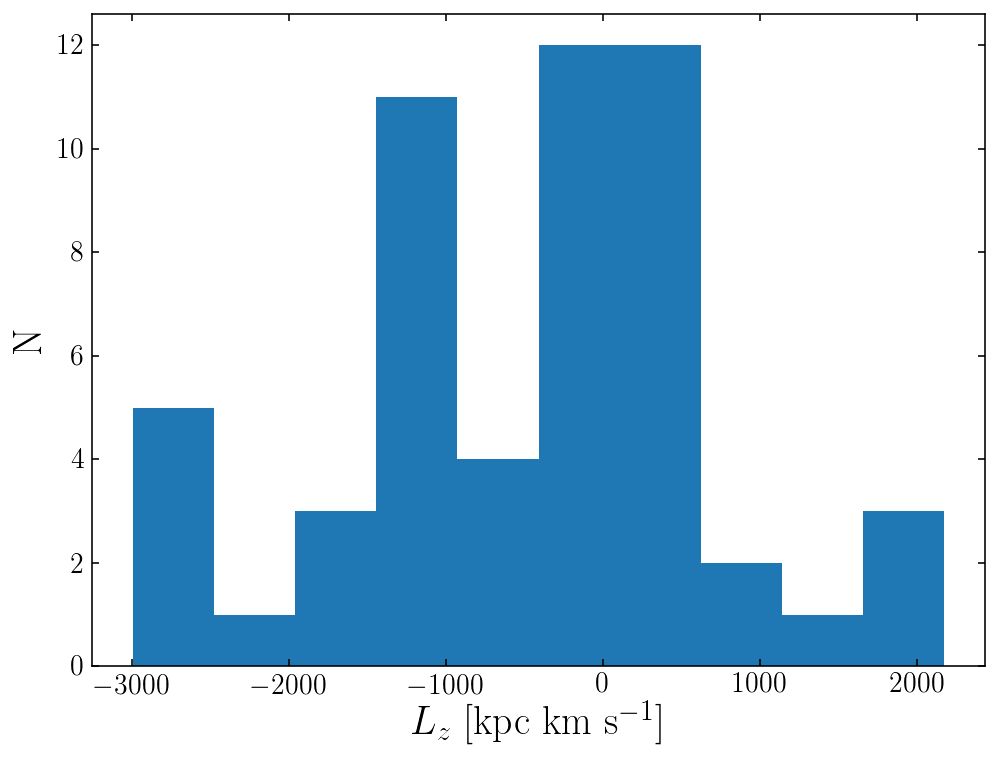

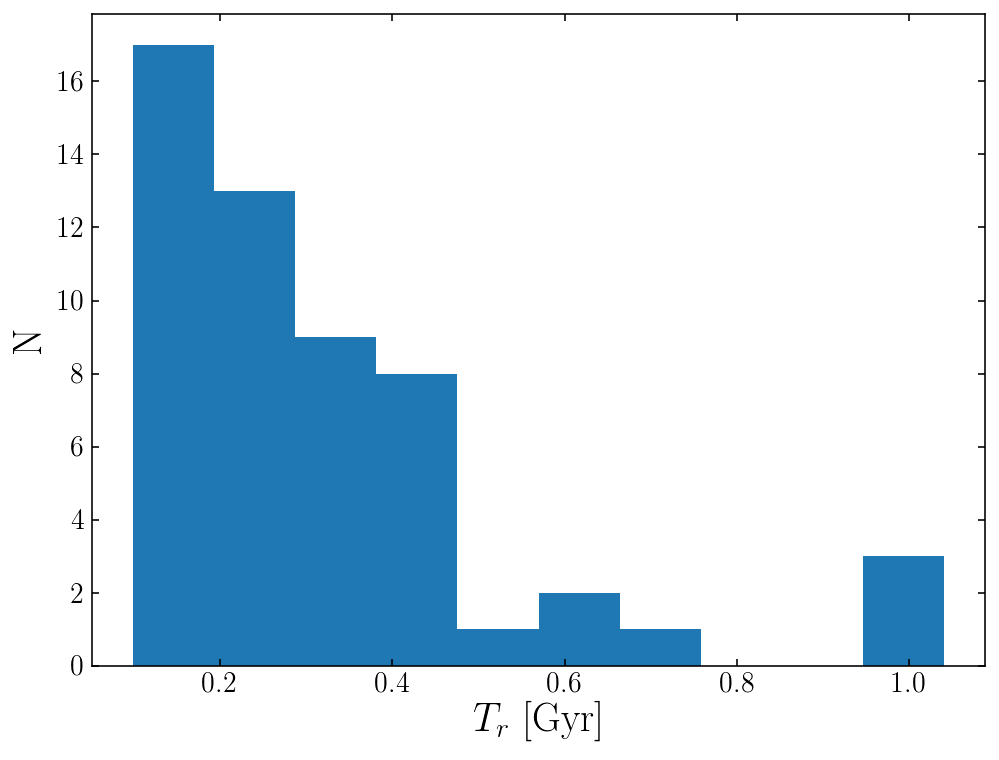

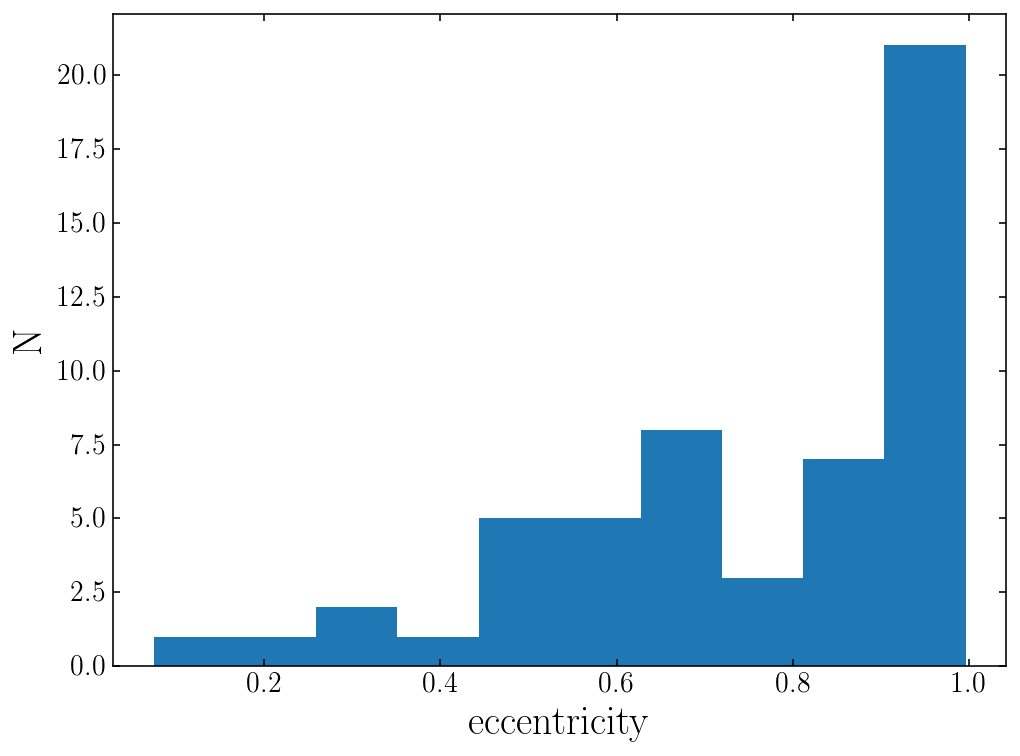

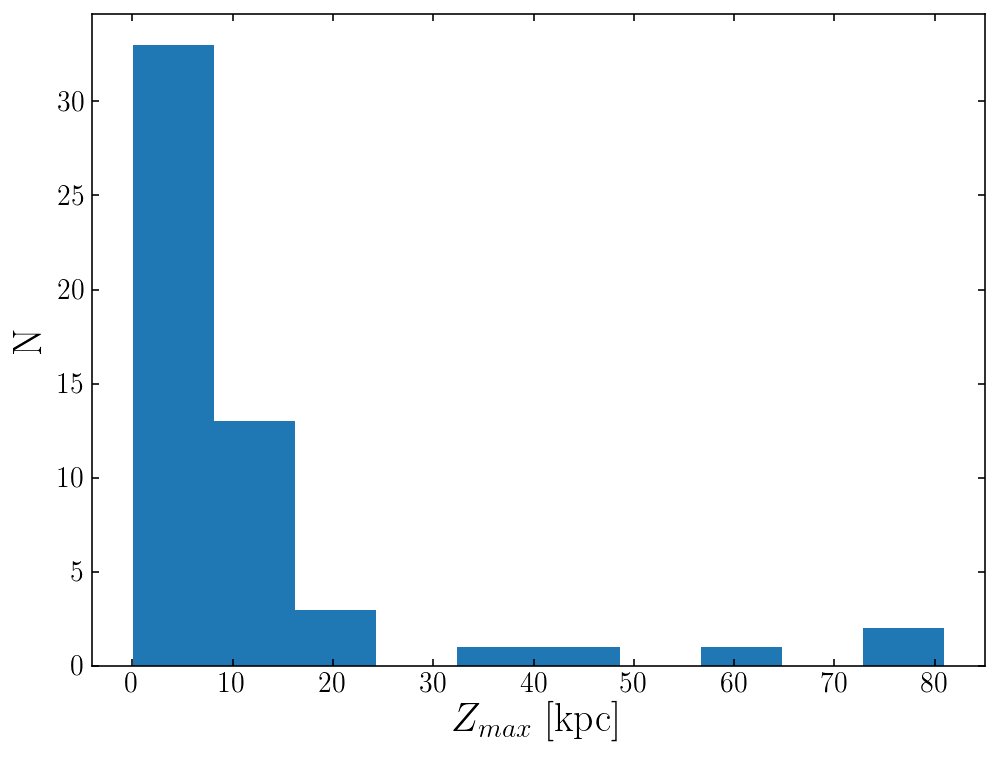

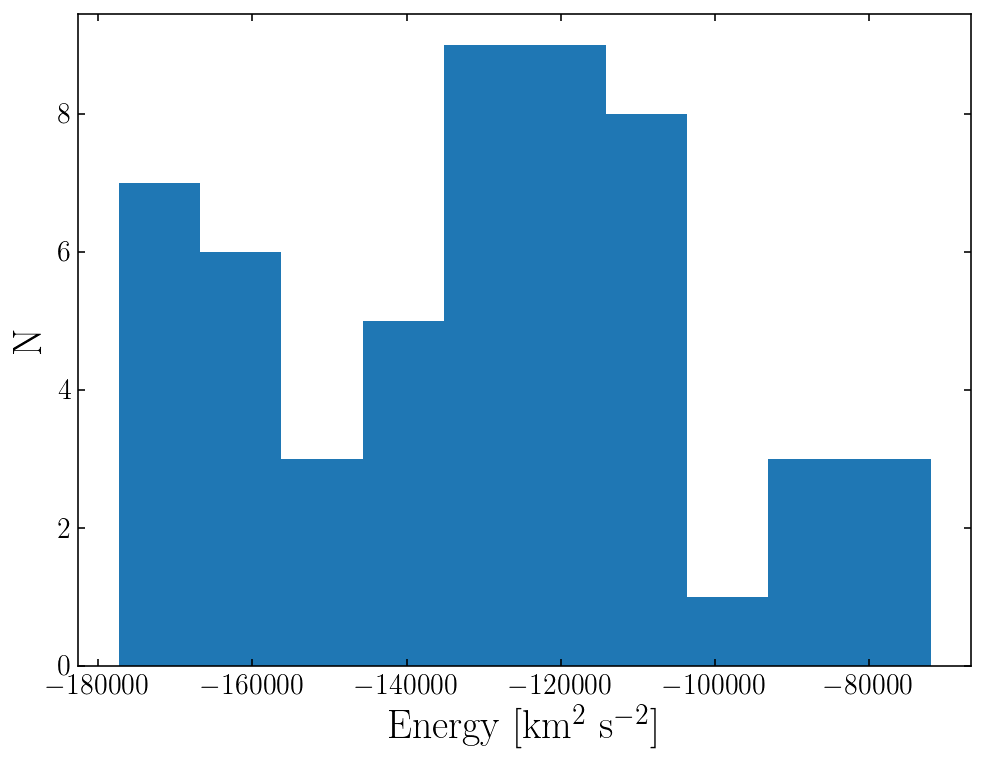

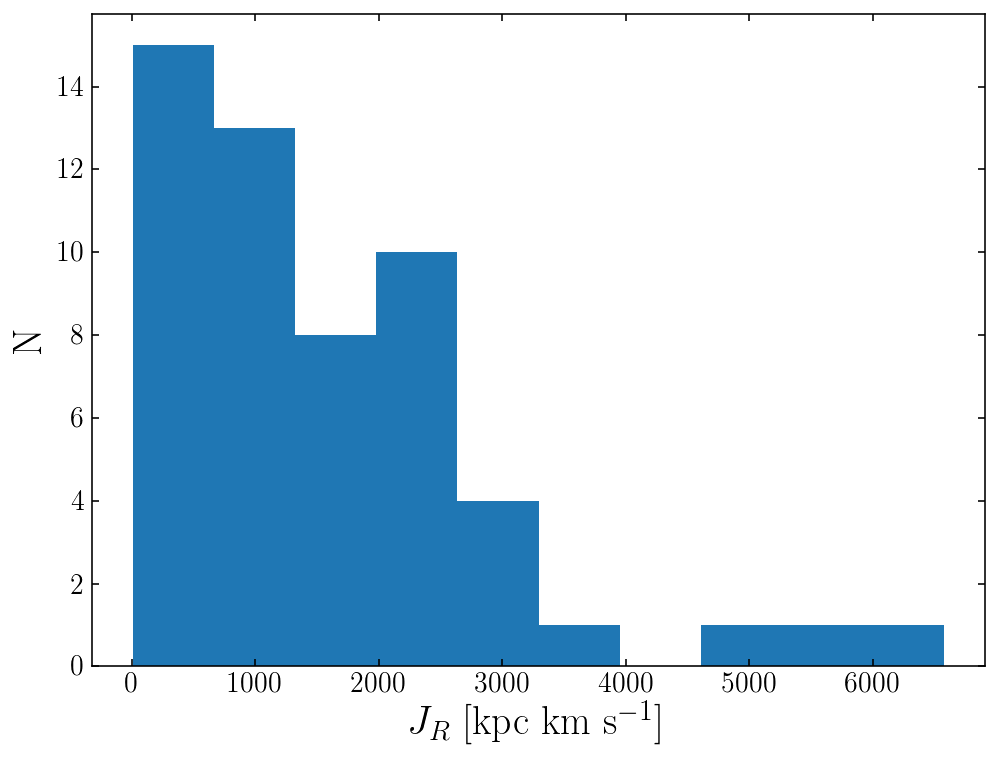

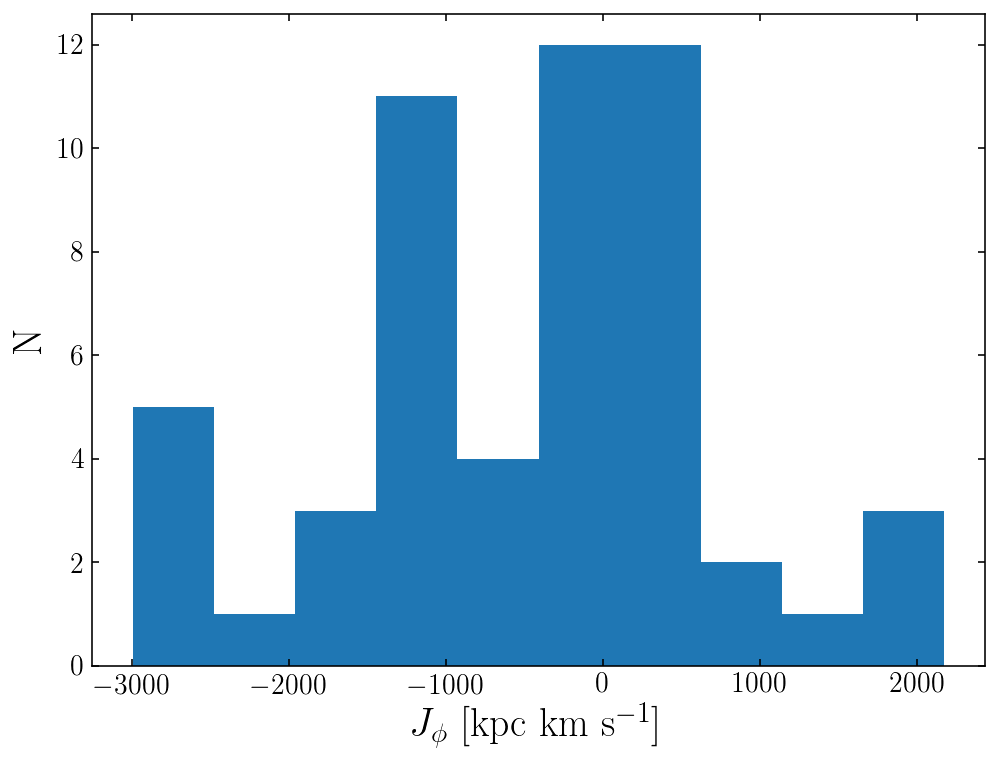

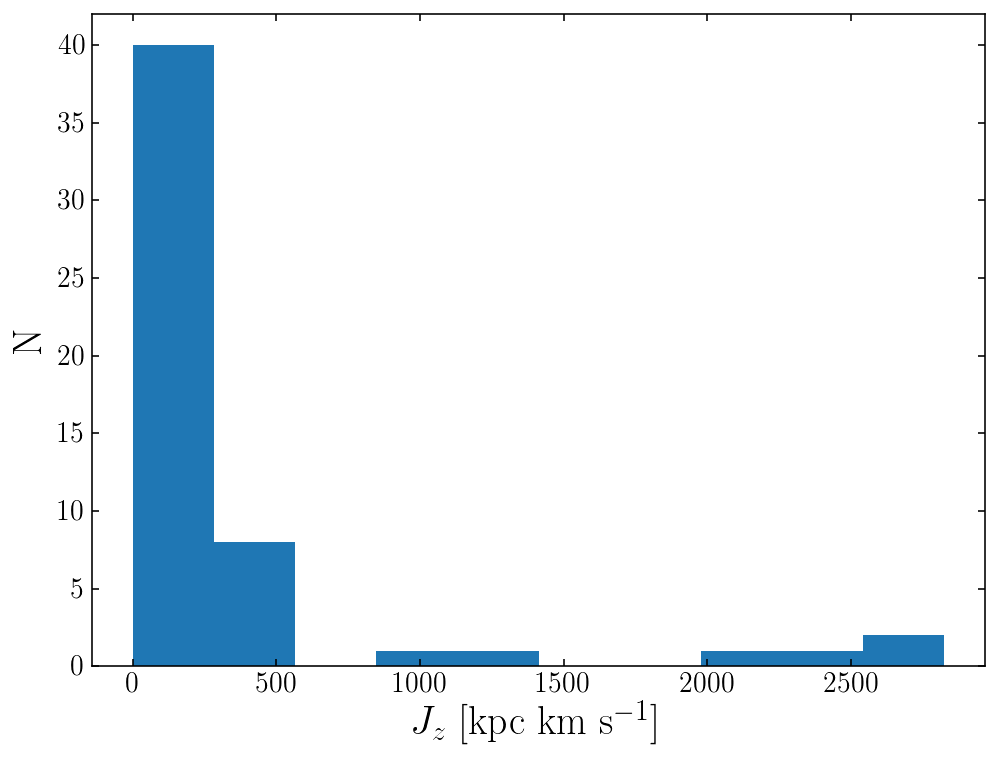

In [59]:
for i in range(n_params):
  
    fig = plt.figure( figsize=(8,6) )
    ax = fig.add_subplot(111)
    
    this_stat = kinematics[:,i,0]
    
    ax.hist( this_stat[ np.isfinite(this_stat) ], bins=10 )
    
    ax.set_xlabel(plot_names[i], fontsize=20)
    ax.set_ylabel('N', fontsize=20)
    ax.tick_params( labelsize=14 )
    
    plt.show()
    
###i

# Make an action map

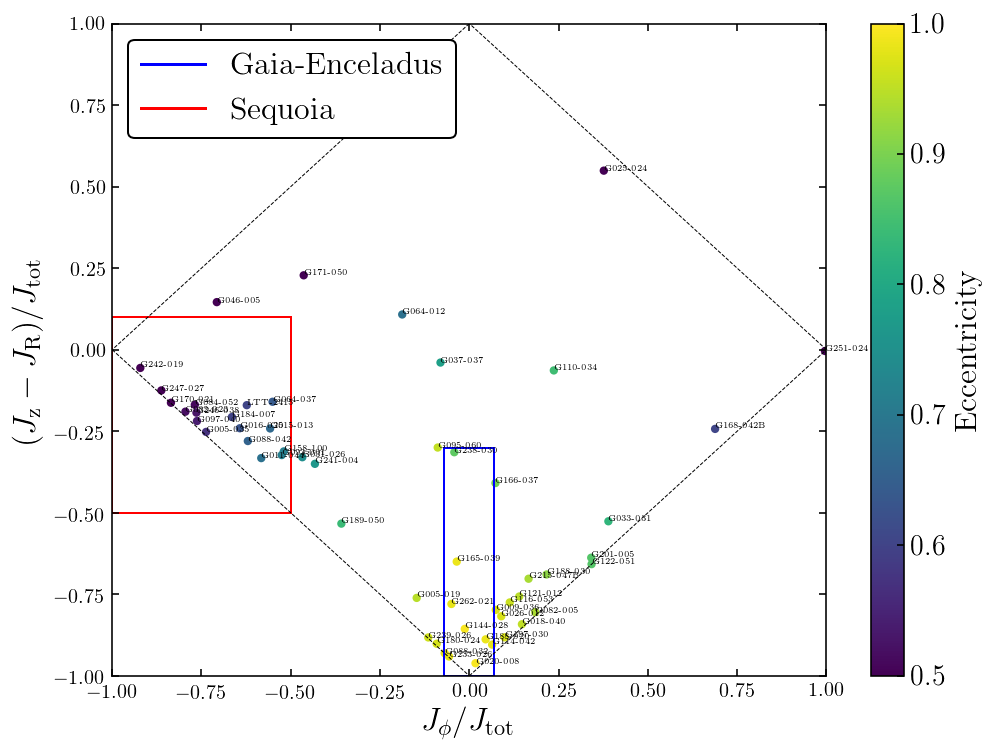

In [92]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

Jr = kinematics[:,7,0]
Jphi = kinematics[:,8,0]
Jz = kinematics[:,9,0]
Jtot = np.abs(Jr)+np.abs(Jphi)+np.abs(Jz)
Jphi_norm = Jphi/Jtot
Jz_Jr_norm = (Jz-Jr)/Jtot
eccen = kinematics[:,4,0]
pts = ax.scatter( Jphi_norm, Jz_Jr_norm, s=10, c=eccen, vmin=0.5, vmax=1.0)

for i in range(n_stars):
    text = vrad_name[i]
    ax.annotate( text, xy=(Jphi_norm[i],Jz_Jr_norm[i]), fontsize=4 )
###i

where_in_GE = np.where( ( Jphi_norm > -0.07 ) &
                        ( Jphi_norm < 0.07 ) &
                        ( Jz_Jr_norm < -0.3)
                      )[0]
where_in_SQ = np.where( ( Jphi_norm < -0.5 ) &
                        ( Jz_Jr_norm < 0.1 )
                      )[0]

cbar = fig.colorbar(pts)
cbar.set_label('Eccentricity', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

ax.set_xlabel(r'$J_{\phi}/J_{\rm tot}$', fontsize=16)
ax.set_ylabel(r'$(J_{\rm z}-J_{\rm R})/J_{\rm tot}$', fontsize=16)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

ax.plot([-1,0], [0,-1], linestyle='dashed', color='Black', linewidth=0.5)
ax.plot([0,1],  [-1,0], linestyle='dashed', color='Black', linewidth=0.5)
ax.plot([1,0],  [0,1],  linestyle='dashed', color='Black', linewidth=0.5)
ax.plot([0,-1], [1,0],  linestyle='dashed', color='Black', linewidth=0.5)

GE_patch = patches.Rectangle( (-0.07,-1), 0.14, 0.7, fill=None, edgecolor='Blue' )
ax.add_artist(GE_patch)
SQ_patch = patches.Rectangle( (-1,-0.5), 0.5, 0.6, fill=None, edgecolor='Red' )
ax.add_artist(SQ_patch)

ax.plot([],[],color='Blue',label='Gaia-Enceladus')
ax.plot([],[],color='Red',label='Sequoia')

ax.legend(loc='upper left', fontsize=16)

plt.savefig('Action_space_map.pdf')
plt.show()

In [94]:
print('In Gaia-Enceladus:')
print(vrad_name[where_in_GE])

print('\nIn Sequoia')
print(vrad_name[where_in_SQ])

In Gaia-Enceladus:
['G088-032' 'G114-042' 'G238-030' 'G165-039' 'G020-008' 'G262-021'
 'G144-028' 'G188-020' 'G233-026']

In Sequoia
['G158-100' 'G005-035' 'G246-038' 'G082-023' 'G247-027' 'G084-052'
 'G097-040' 'LTT-2415' 'G088-042' 'G011-044' 'G064-037' 'G015-013'
 'G016-025' 'G170-021' 'G184-007' 'G093-001' 'G242-019']


# Output catalog

In [95]:
output_names = ('Name','rp','rperi_err','rapo','rapo_err','Lz','Lz_err','Tr','Tr_err','Eccen','Eccen_err','Zmax',
                'Zmax_err','Energy','Energy_err','Jr','Jr_err','Jphi','Jphi_err','Jz','Jz_err')

output_dtypes = ('U10','float','float','float','float','float','float','float','float','float','float',
                 'float','float','float','float','float','float','float','float','float','float')

output_table = table.Table( [vrad_name, 
                             kinematics[:,0,0], np.average([kinematics[:,0,1],kinematics[:,0,2]], axis=0), 
                             kinematics[:,1,0], np.average([kinematics[:,1,1],kinematics[:,1,2]], axis=0), 
                             kinematics[:,2,0], np.average([kinematics[:,2,1],kinematics[:,2,2]], axis=0), 
                             kinematics[:,3,0], np.average([kinematics[:,3,1],kinematics[:,3,2]], axis=0), 
                             kinematics[:,4,0], np.average([kinematics[:,4,1],kinematics[:,4,2]], axis=0),
                             kinematics[:,5,0], np.average([kinematics[:,5,1],kinematics[:,5,2]], axis=0),
                             kinematics[:,6,0], np.average([kinematics[:,6,1],kinematics[:,6,2]], axis=0),
                             kinematics[:,7,0], np.average([kinematics[:,7,1],kinematics[:,7,2]], axis=0),
                             kinematics[:,8,0], np.average([kinematics[:,8,1],kinematics[:,8,2]], axis=0),
                             kinematics[:,9,0], np.average([kinematics[:,9,1],kinematics[:,9,2]], axis=0)
                             ], names = output_names, dtype=output_dtypes
                           )
output_table.write('./SB02_orbit_parameters.FIT', overwrite=True)